## Adaptation of CI - A multi-level approach
In this example we demonstrate how adaptations of different levels (hazard-, asset-, network- and system-level) can be appraised based on their cost of adaptation, risk, and benefits of adaptation. This notebook covers the calculation of future risk and future risk discounting, adaptation maintenance costs, benefit discounting and benefit to cost ratios.


In [55]:
import os
# os.chdir('path/to/book/directory')
# os.chdir('..')
from src.ci_adapt_utilities import *
import matplotlib.pyplot as plt
import math 

data_path = Path(os.getcwd() + '/data')
interim_data_path = data_path / 'interim' / 'collected_flood_runs'


Load default configuration and model parameters

In [56]:
config_file=Path(os.getcwd() + '/config_ci_adapt_test.ini')
hazard_type, infra_type, country_code, country_name, hazard_data_subfolders, asset_data, vulnerability_data = load_config(config_file)

Define paths for adaptations, basins, and region (for visualisation)

In [57]:
adaptations_df_dir = data_path / 'interim' / 'adaptations'
basins_path = data_path / 'Floods' / 'basins' / 'hybas_eu_lev01-12_v1c' / 'hybas_eu_lev08_v1c_valid.shp'
regions_path = data_path / r'visualisation\rhineland_palatinate.geojson'

regions_gdf = gpd.read_file(regions_path)
basins_gdf_0 = load_basins_in_region(basins_path, regions_path, clipping=True)
basin_list_tributaries, basin_list_full_flood = find_basin_lists(basins_gdf_0)


Load asset data, adaptation cost data, and results from baseline (no adaptation) risk and adapted risk (with adaptations)

In [58]:
assets, geom_dict, miraca_colors, return_period_dict, adaptation_unit_costs, rp_spec_priority, average_road_cost_per_ton_km, average_train_cost_per_ton_km, average_train_load_tons = startup_ci_adapt(data_path, config_file, interim_data_path)
shortest_paths, disrupted_edges_by_basin, graph_r0, disrupted_shortest_paths, event_impacts, full_flood_event, all_disrupted_edges, collect_output = load_baseline_impact_assessment(data_path)

675 assets loaded.
Loaded data from baseline impact assessment


In [59]:
event_impacts = {haz_map: event_impacts[haz_map] if haz_map in event_impacts.keys() else 0.0 for haz_map in collect_output.keys()}
direct_damages_baseline_sum = {haz_map: (sum(v[0] for v in collect_output[haz_map].values()), sum(v[1] for v in collect_output[haz_map].values())) for haz_map in collect_output}

In [60]:
# Find basins that have damaged assets
overlay_files = [file for file in os.listdir(interim_data_path) if file.endswith('.pkl') and file.startswith('overlay')]
basins_list = list(set([int(file.split('.')[0].split('_')[-1]) for file in overlay_files]))

Define some tag names for clarity in output

In [61]:
dict_tags_names = {'l1': 'L1: flood wall', 
                         'l2': 'L2: elevate rail (viaduct)', 
                         'l3': 'L3: build new connection', 
                         'l4': 'L4: reduce demand', 
                         'trib': 'Study Area 2',
                         'rhine': 'Study Area 1',
                         'baseline': 'No adaptation',
                         'upper bound': 'Future C (discounted)',
                         'lower bound': 'Future A (discounted)', 
                         'mean': 'Future B (discounted)'}

Calculate the return period frequencies under climate change and define discount rate for future damages discounting

In [62]:
increase_factors_bounds = {'lower bound':{'_H_': 2, '_M_': 1.75, '_L_': 1.82},
                            'mean':{'_H_': 2, '_M_': 4.21, '_L_': 5.86},
                            'upper bound':{'_H_': 2, '_M_': 6.67, '_L_': 9.09}}
num_years = 100
# return_period_dict = {'_H_': 10,'_M_': 100,'_L_': 200} # initial return periods for the different hazard maps
dynamic_rps={inc_f:calculate_dynamic_return_periods(return_period_dict, num_years, increase_factors_bounds[inc_f]) for inc_f in increase_factors_bounds.keys()}
discount_rate_percent = 1 # (Define discounting rate for future benefits)

Calculate future damages under climate change without adaptation (baseline)

In [63]:
#Calculate baseline results for future conditions
adapt_id='baseline'

baseline_results_dict = {}
eadD_bl_by_ts_basin_incf = {}
eadIT_bl_by_ts_basin_incf = {}

direct_damages_adapted, indirect_damages_adapted, indirect_damages_adapted_full, adapted_assets, adaptation_costs, adaptations_df = load_adaptation_impacts(adapt_id, data_path)
total_damages_adapted_df_mill=process_raw_adaptations_output(direct_damages_baseline_sum, direct_damages_adapted, event_impacts, indirect_damages_adapted, adaptations_df)

for inc_f in increase_factors_bounds.keys():
    return_periods = dynamic_rps[inc_f] 

    ead_y0_dd_bl_all, ead_y100_dd_bl_all, total_dd_bl_all, eadD_bl_by_ts_basin_incf[inc_f] = compile_direct_risk(inc_f, return_periods, basins_list, collect_output, total_damages_adapted_df_mill, discount_rate_percent)
    ead_y0_id_bl_all, ead_y100_id_bl_all, total_id_bl_all,  eadIT_bl_by_ts_basin_incf[inc_f] = compile_indirect_risk_tributaries(inc_f, return_periods, basins_list, basin_list_tributaries, collect_output, total_damages_adapted_df_mill, discount_rate_percent)
    ead_y0_id_bl_full, ead_y100_id_bl_full, total_id_bl_full = compile_indirect_risk_full_flood(return_periods, indirect_damages_adapted_full, discount_rate_percent)

    baseline_results_dict[inc_f] = {'ead_y0_dd_bl_all': ead_y0_dd_bl_all, 'ead_y100_dd_bl_all': ead_y100_dd_bl_all, 'total_dd_bl_all': total_dd_bl_all,
                                        'ead_y0_id_bl_all': ead_y0_id_bl_all[0], 'ead_y100_id_bl_all': ead_y100_id_bl_all[0], 'total_id_bl_all': total_id_bl_all[0],
                                        'ead_y0_id_bl_full': ead_y0_id_bl_full, 'ead_y100_id_bl_full': ead_y100_id_bl_full, 'total_id_bl_full': total_id_bl_full}   

In [64]:
#Baseline damages and losses by return period
direct_damages_adapted, indirect_damages_adapted, indirect_damages_adapted_full, adapted_assets, adaptation_costs, adaptations_df = load_adaptation_impacts(adapt_id, data_path)
total_damages_adapted_df_mill=process_raw_adaptations_output(direct_damages_baseline_sum, direct_damages_adapted, event_impacts, indirect_damages_adapted, adaptations_df)

total_damages_adapted_df_mill
total_damages_adapted_df_mill['basin'] = total_damages_adapted_df_mill.index
total_damages_adapted_df_mill['basin'] = total_damages_adapted_df_mill['basin'].apply(lambda x: int(x.split('_')[-1]))
total_damages_adapted_df_mill['direct damage baseline avg [M€]'] = (total_damages_adapted_df_mill['direct damage baseline lower [M€]'] + total_damages_adapted_df_mill['direct damage baseline upper [M€]'])/2
total_damages_adapted_df_mill['indirect damage baseline_tributaries [M€]'] = np.where(total_damages_adapted_df_mill['basin'].isin(basin_list_tributaries), total_damages_adapted_df_mill['indirect damage baseline [M€]'], 0)
total_damages_adapted_df_mill_sum = total_damages_adapted_df_mill.groupby(['return_period'], observed=True).sum().reset_index()

# keep only return_period direct damage baseline lower [M€]	direct damage baseline upper [M€]	indirect damage baseline_tributaries [M€]
keep_cols = ['return_period', 'direct damage baseline avg [M€]', 'direct damage baseline lower [M€]', 'direct damage baseline upper [M€]', 'indirect damage baseline_tributaries [M€]']
drop_cols = [col for col in total_damages_adapted_df_mill_sum.columns  if col not in keep_cols]
total_damages_adapted_df_mill_sum.drop(columns=[col for col in drop_cols if col in total_damages_adapted_df_mill_sum.columns], inplace=True)

return_period_keys = {'H': 'flood_DERP_RW_H', 'M': 'flood_DERP_RW_M', 'L': 'flood_DERP_RW_L'}
total_damages_adapted_df_mill_sum['indirect damage baseline_mainstem [M€]'] = [
    full_flood_event[return_period_keys[x.split('_')[-1]]] / 1e6 for x in total_damages_adapted_df_mill_sum['return_period']
]
# turn all values to integers except return_period
for col in total_damages_adapted_df_mill_sum.columns:
    if col != 'return_period':
        total_damages_adapted_df_mill_sum[col] = total_damages_adapted_df_mill_sum[col].apply(lambda x: int(x))

Calculate adaptations under future conditions

In [65]:
# Calculate results for adapted conditions
adaptation_files = [file for file in os.listdir(adaptations_df_dir) if file.endswith('.csv')]
adapt_ids = [file.split('_adaptations')[0] for file in adaptation_files]

adapted_results_dict = {}
adaptation_cost_dict = {}
eadD_ad_by_ts_basin_incf = {}
eadIT_ad_by_ts_basin_incf = {}

for adapt_id in adapt_ids:
    direct_damages_adapted, indirect_damages_adapted, indirect_damages_adapted_full, adapted_assets, adaptation_costs, adaptations_df = load_adaptation_impacts(adapt_id, data_path)
    total_damages_adapted_df_mill=process_raw_adaptations_output(direct_damages_baseline_sum, direct_damages_adapted, event_impacts, indirect_damages_adapted, adaptations_df)
    adaptation_cost_dict[adapt_id] = adaptation_costs    
    
    if adapt_id not in adapted_results_dict.keys():
        adapted_results_dict[adapt_id] = {}
        eadD_ad_by_ts_basin_incf[adapt_id] = {}
        eadIT_ad_by_ts_basin_incf[adapt_id] = {}
    for inc_f in increase_factors_bounds.keys():
        if inc_f not in adapted_results_dict[adapt_id]:
            adapted_results_dict[adapt_id][inc_f] = {}
        
        return_periods = dynamic_rps[inc_f]

        print(adapt_id, inc_f)

        ead_y0_dd_ad_all, ead_y100_dd_ad_all, total_dd_ad_all, eadD_ad_by_ts_basin_incf[adapt_id][inc_f]  = compile_direct_risk(inc_f, return_periods, basins_list, collect_output, total_damages_adapted_df_mill, discount_rate_percent=discount_rate_percent)
        ead_y0_id_ad_all, ead_y100_id_ad_all, total_id_ad_all, eadIT_ad_by_ts_basin_incf[adapt_id][inc_f] = compile_indirect_risk_tributaries(inc_f, return_periods, basins_list, basin_list_tributaries, collect_output, total_damages_adapted_df_mill, discount_rate_percent=discount_rate_percent)
        ead_y0_id_ad_full, ead_y100_id_ad_full, total_id_ad_full = compile_indirect_risk_full_flood(return_periods, indirect_damages_adapted_full, discount_rate_percent=discount_rate_percent)

        adapted_results_dict[adapt_id][inc_f] = {'ead_y0_dd_ad_all': ead_y0_dd_ad_all, 'ead_y100_dd_ad_all': ead_y100_dd_ad_all, 'total_dd_ad_all': total_dd_ad_all,
                                                'ead_y0_id_ad_all': ead_y0_id_ad_all[0], 'ead_y100_id_ad_all': ead_y100_id_ad_all[0], 'total_id_ad_all': total_id_ad_all[0],
                                                'ead_y0_id_ad_full': ead_y0_id_ad_full, 'ead_y100_id_ad_full': ead_y100_id_ad_full, 'total_id_ad_full': total_id_ad_full}

baseline lower bound
baseline mean
baseline upper bound
l1_trib lower bound
l1_trib mean
l1_trib upper bound
l2_trib lower bound
l2_trib mean
l2_trib upper bound
l3_trib lower bound
l3_trib mean
l3_trib upper bound
l4_trib lower bound
l4_trib mean
l4_trib upper bound


Output discounted future risk

In [66]:


future_risk_df = pd.DataFrame()

risk_components = ['Direct damage [M€]', 'Indirect losses tributaries [M€]', 'Indirect losses mainstem [M€]']
increase_factors = ['lower bound', 'mean', 'upper bound']

future_risk_df['Risk component'] = risk_components
future_risk_df['Year 0 (undiscounted)'] = [(baseline_results_dict['mean']['ead_y0_dd_bl_all'][0]+baseline_results_dict['mean']['ead_y0_dd_bl_all'][1])/2, baseline_results_dict['mean']['ead_y0_id_bl_all'], baseline_results_dict['mean']['ead_y0_id_bl_full']]

for inc_f in increase_factors:
    future_risk_df[dict_tags_names[inc_f]] = [(baseline_results_dict[inc_f]['ead_y100_dd_bl_all'][0]+baseline_results_dict[inc_f]['ead_y100_dd_bl_all'][1])/2, baseline_results_dict[inc_f]['ead_y100_id_bl_all'], baseline_results_dict[inc_f]['ead_y100_id_bl_full']]

# add all components
future_risk_df=future_risk_df.T
future_risk_df['total'] = future_risk_df.sum(axis=1)
future_risk_df=future_risk_df.T 
future_risk_df.loc['total', 'Risk component'] = 'Total [M€]'

future_risk_df.index = future_risk_df['Risk component']
future_risk_df.drop(columns=['Risk component'], inplace=True)
future_risk_df.to_csv(data_path / 'output' / 'future_risk_df.csv')
future_risk_df


,Year 0 (undiscounted),Future A (discounted),Future B (discounted),Future C (discounted)
Risk component,,,,
Direct damage [M€],1.680,1.153,1.844,2.480
Indirect losses tributaries [M€],0.731,0.444,0.669,0.876
Indirect losses mainstem [M€],2.048,1.180,1.963,2.678
Total [M€],4.460,2.778,4.477,6.034


Calculate total discounted adaptation costs including initial cost and maintenance

In [67]:
# Process adaptation costs and benefits for different levels and incorporate yearly maintenance costs
yearly_maintenance_percent = {'l1': 1.0, 'l2': 1.0, 'l3': 1.0}
maintenance_pc_dict = discount_maintenance_costs(yearly_maintenance_percent, discount_rate_percent, num_years)

processed_adaptation_costs = process_adaptation_costs(adaptation_cost_dict, maintenance_pc_dict)

# Find the avoided damages
avoided_damages_dict = {}
for adapt_id in adapt_ids:
    if adapt_id not in adapted_results_dict:
        continue
    avoided_damages_dict[adapt_id] = {}
    for inc_f in increase_factors_bounds.keys():
        avoided_damages_dict[adapt_id][inc_f] = {}
        for key in baseline_results_dict[inc_f].keys():
            key_ad=key.replace('bl','ad')
            key_diff=key.replace('bl','diff')
            avoided_damages_dict[adapt_id][inc_f][key_diff] = baseline_results_dict[inc_f][key] - adapted_results_dict[adapt_id][inc_f][key_ad]

benefits_dict = {}
for adapt_id in adapt_ids:
    benefits_dict[adapt_id] = {}
    for inc_f in increase_factors_bounds.keys():
        benefits_dict[adapt_id][inc_f] = {}
        total_avoided_damages_y0 = avoided_damages_dict[adapt_id][inc_f]['ead_y0_dd_diff_all'] + avoided_damages_dict[adapt_id][inc_f]['ead_y0_id_diff_all'] + avoided_damages_dict[adapt_id][inc_f]['ead_y0_id_diff_full']
        total_avoided_damages_y100 = avoided_damages_dict[adapt_id][inc_f]['ead_y100_dd_diff_all'] + avoided_damages_dict[adapt_id][inc_f]['ead_y100_id_diff_all'] + avoided_damages_dict[adapt_id][inc_f]['ead_y100_id_diff_full']
        total_avoided_damages_full_period = avoided_damages_dict[adapt_id][inc_f]['total_dd_diff_all'] + avoided_damages_dict[adapt_id][inc_f]['total_id_diff_all'] + avoided_damages_dict[adapt_id][inc_f]['total_id_diff_full']
        benefits_dict[adapt_id][inc_f] = {'total_avoided_damages_y0': total_avoided_damages_y0, 'total_avoided_damages_y100': total_avoided_damages_y100, 'total_avoided_damages_full_period': total_avoided_damages_full_period}

Calculate the benefit to cost ratios for each adaptation under each future conditions and save results

In [68]:
adapt_ids=benefits_dict.keys()
bcr_df = pd.DataFrame()

for adapt_id in adapt_ids:
    for inc_f in increase_factors_bounds.keys():
        total_adaptation_cost = processed_adaptation_costs[adapt_id]
        total_avoided_damages = benefits_dict[adapt_id][inc_f]['total_avoided_damages_full_period']
        bcr = total_avoided_damages / total_adaptation_cost if total_adaptation_cost != 0 else math.nan
        bcr = np.nan_to_num(bcr, nan=0)
        # bcr = bcr if bcr != math.nan else 0
        bcr_mean = bcr.mean()
        total_avoided_damages_mean = total_avoided_damages.mean()
        new_df = pd.DataFrame({(adapt_id,inc_f): [total_adaptation_cost, total_avoided_damages_mean, bcr_mean, total_avoided_damages, bcr]}, index=['total_adaptation_cost', 'total_avoided_damages_mean','bcr_mean', 'total_avoided_damages', 'bcr']).T
        bcr_df = pd.concat([bcr_df, new_df])
        
adapt_ids_output = ['baseline', 'l1_trib', 'l2_trib','l3_trib','l4_trib']#, 'l1_rhine', 'l2_rhine', 'l3_rhine', 'l4_rhine']

bcr_df.sort_values('bcr_mean', ascending=False)
bcr_df = bcr_df[bcr_df.index.get_level_values(0).isin(adapt_ids_output)].copy()

# Turn the total avoided damages and bcr columns into separate columns for the upper and lower bounds
bcr_df.loc[:, 'total_avoided_damages_lower'] = bcr_df['total_avoided_damages'].apply(lambda x: x[0])
bcr_df.loc[:, 'total_avoided_damages_upper'] = bcr_df['total_avoided_damages'].apply(lambda x: x[1])
bcr_df.loc[:, 'bcr_lower'] = bcr_df['bcr'].apply(lambda x: x[0] if np.all(x != 0) else 0)
bcr_df.loc[:, 'bcr_upper'] = bcr_df['bcr'].apply(lambda x: x[1] if np.all(x != 0) else 0)

bcr_df.to_csv(data_path / 'output' / 'bcr_df.csv')

bcr_df    

total_adaptation_cost total_avoided_damages_mean  \
baseline lower bound                 0.000                      0.000   
         mean                        0.000                      0.000   
         upper bound                 0.000                      0.000   
l1_trib  lower bound               435.727                     15.079   
         mean                      435.727                     21.343   
         upper bound               435.727                     27.082   
l2_trib  lower bound             1,360.178                     91.740   
         mean                    1,360.178                    117.468   
         upper bound             1,360.178                    141.086   
l3_trib  lower bound               215.266                      0.000   
         mean                      215.266                      0.000   
         upper bound               215.266                      0.000   
l4_trib  lower bound                 0.000                     22.575   
         mean                        0.000                     27.705   
         upper bound                 0.000                     32.402   

                     bcr_mean                     total_avoided_damages  \
baseline lower bound    0.000                                [0.0, 0.0]   
         mean           0.000                                [0.0, 0.0]   
         upper bound    0.000                                [0.0, 0.0]   
l1_trib  lower bound    0.035   [9.835288626903797, 20.321839491874066]   
         mean           0.049      [12.894443627457846, 29.79207338101]   
         upper bound    0.062   [15.707917480960631, 38.45673467131418]   
l2_trib  lower bound    0.067    [80.3712624376798, 103.10815552773397]   
         mean           0.086  [101.15376818733411, 133.78196378511302]   
         upper bound    0.104    [120.23621758971255, 161.936087897667]   
l3_trib  lower bound    0.000                                [0.0, 0.0]   
         mean           0.000                                [0.0, 0.0]   
         upper bound    0.000                                [0.0, 0.0]   
l4_trib  lower bound    0.000  [22.574833550930002, 22.574833550930002]   
         mean           0.000    [27.70503439170446, 27.70503439170446]   
         upper bound    0.000  [32.401510638587496, 32.401510638587496]   

                                                              bcr  \
baseline lower bound                                        0.000   
         mean                                               0.000   
         upper bound                                        0.000   
l1_trib  lower bound   [0.02257212506556448, 0.04663890608336039]   
         mean           [0.0295929286115394, 0.06837322541599164]   
         upper bound  [0.036049890486175566, 0.08825874435851716]   
l2_trib  lower bound   [0.05908880173698988, 0.07580492298685948]   
         mean          [0.07436806107164799, 0.09835624941456263]   
         upper bound    [0.08839744216128304, 0.1190551087743402]   
l3_trib  lower bound                                   [0.0, 0.0]   
         mean                                          [0.0, 0.0]   
         upper bound                                   [0.0, 0.0]   
l4_trib  lower bound                                        0.000   
         mean                                               0.000   
         upper bound                                        0.000   

                      total_avoided_damages_lower  \
baseline lower bound                        0.000   
         mean                               0.000   
         upper bound                        0.000   
l1_trib  lower bound                        9.835   
         mean                              12.894   
         upper bound                       15.708   
l2_trib  lower bound                       80.371   
         mean                             101.154   
         upper bound                      120.236   
l3_trib  lower b

Create visualisation of BCRs

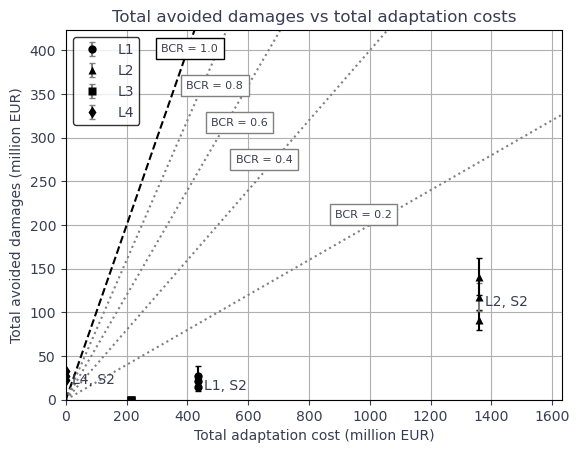

In [69]:
# Create a scatter plot of total avoided damages vs total adaptation costs, consider the upper and lower bounds as error bars
fig, ax = plt.subplots()

# Add BCR lines
x = np.linspace(0, max(2*bcr_df['total_adaptation_cost']), 100)
y = x
ax.plot(x, y, ls='dashed', color='black')
for i in range(2, 10, 2):
    y = i/10 * x
    ax.plot(x, y, ls='dotted', color='grey')

# Set the y axis to the maximum value of the total avoided damages*1.2
max_x = 1.2 * bcr_df['total_adaptation_cost'].max()
max_y = 3 * bcr_df['total_avoided_damages_mean'].max()

ax.set_xlim(0, max_x)
ax.set_ylim(0, max_y)

bcr_texts = {1.0: (max_x * 0.25, max_y * 0.95), 
             0.8: (max_x * 0.3, max_y * 0.85), 
             0.6: (max_x * 0.35, max_y * 0.75), 
             0.4: (max_x * 0.4, max_y * 0.65), 
             0.2: (max_x * 0.6, max_y * 0.5)}

for i in bcr_texts.keys():
    if i == 1.0:
        ax.text(bcr_texts[i][0], bcr_texts[i][1], f'BCR = {i}', fontsize=8, verticalalignment='center', horizontalalignment='center', bbox = dict(facecolor='white', edgecolor='black'))
    else:   
        ax.text(bcr_texts[i][0], bcr_texts[i][1], f'BCR = {i}', fontsize=8, verticalalignment='center', horizontalalignment='center', bbox = dict(facecolor='white', edgecolor='grey'))

markers = {
    'baseline': 'o',  # empty circle
    'l1': 'o',        # full circle
    'l2': '^',        # triangle
    'l3': 's',        # square
    'l4': 'd'         # diamond
}

# Create a dictionary to store handles for the legend
handles = {}
for adapt_id in adapt_ids_output:
    if "baseline" in adapt_id:continue
    if "rhine" in adapt_id:
        study_area = "S1"
    elif "trib" in adapt_id:
        study_area = "S2"
    else:
        study_area = "NA"

    for inc_f in increase_factors_bounds.keys():
        x = bcr_df.loc[(adapt_id, inc_f), 'total_adaptation_cost']
        y = bcr_df.loc[(adapt_id, inc_f), 'total_avoided_damages_mean']
        yerr = [[y - bcr_df.loc[(adapt_id, inc_f), 'total_avoided_damages_lower']], [bcr_df.loc[(adapt_id, inc_f), 'total_avoided_damages_upper'] - y]]
                
        marker_style = markers.get(adapt_id.split('_')[0], 'x')
        markerfacecolor = 'none' if adapt_id == 'baseline' else 'black'
        
        if inc_f == 'mean':
            ax.annotate(f'{(adapt_id.split('_')[0]).upper()}, {study_area}', (x+20, y-10))
            handle = ax.errorbar(x, y, yerr=yerr, fmt=marker_style, label=f'{adapt_id} {inc_f}', markerfacecolor=markerfacecolor, markeredgecolor='none', color='grey', capsize=2)        
            generic_adapt_id = adapt_id.split('_')[0]
            if generic_adapt_id not in handles:
                handles[generic_adapt_id] = handle
        else:
            handle = ax.errorbar(x, y, yerr=yerr, fmt=marker_style, markerfacecolor=markerfacecolor, markeredgecolor='none', color='black', capsize=2)        
            pass
        
ax.set_xlabel('Total adaptation cost (million EUR)')
ax.set_ylabel('Total avoided damages (million EUR)')
ax.set_title('Total avoided damages vs total adaptation costs')
ax.legend([value for value in handles.values()], [key.upper() for key in handles.keys()], facecolor='white', edgecolor='black', loc='upper left')
ax.grid(True)

plt.show()


Find adaptations that have a BCR greater than 1

In [70]:
# Find adaptations with BCR greater than 1 under all increase factors
adaptations_with_bcr_greater_than_1 = []
for adapt_id in adapt_ids_output:
    bcr_values = bcr_df.loc[adapt_id]['bcr_mean']
    if all(bcr > 1 for bcr in bcr_values):
        adaptations_with_bcr_greater_than_1.append(adapt_id)
print(f'No-regret: Adaptations with BCR greater than 1 under all increase factors: {adaptations_with_bcr_greater_than_1}')

# Find adaptations with BCR greater than 1 in at least one increase factor but not all 3
adaptations_with_bcr_greater_than_1_some = []
for adapt_id in adapt_ids_output:
    bcr_values = bcr_df.loc[adapt_id]['bcr_mean']
    if any(bcr > 1 for bcr in bcr_values) and not all(bcr > 1 for bcr in bcr_values):
        adaptations_with_bcr_greater_than_1_some.append(adapt_id)
print(f'Adaptations with BCR greater than 1 in at least one increase factor but not all 3: {adaptations_with_bcr_greater_than_1_some}')

# Find adaptations with BCR less than 1 in all increase factors
adaptations_with_bcr_less_than_1 = []
for adapt_id in adapt_ids_output:
    bcr_values = bcr_df.loc[adapt_id]['bcr_mean']
    if all(bcr < 1 for bcr in bcr_values):
        adaptations_with_bcr_less_than_1.append(adapt_id)
print(f'Economically inefficient: Adaptations with BCR less than 1 in all increase factors: {adaptations_with_bcr_less_than_1}')

No-regret: Adaptations with BCR greater than 1 under all increase factors: []
Adaptations with BCR greater than 1 in at least one increase factor but not all 3: []
Economically inefficient: Adaptations with BCR less than 1 in all increase factors: ['baseline', 'l1_trib', 'l2_trib', 'l3_trib', 'l4_trib']


Generate detailed output and maps

In [71]:
# Create a DataFrame with the benefits for each adaptation and increase factor by appending each new Series to the previous one
avoided_damages_df = pd.DataFrame()
for adapt_id in adapt_ids_output:
    for inc_f in increase_factors_bounds.keys():
        new_df = pd.Series(avoided_damages_dict[adapt_id][inc_f], name=(adapt_id, inc_f))
        avoided_damages_df = pd.concat([avoided_damages_df, new_df], axis=1)

avoided_damages_df = avoided_damages_df.T

avoided_damages_df.columns = ['Avoided Direct Y0 [M€/y]', 'Avoided Direct Y100 [M€/y]', 'Avoided Direct Total [M€]', 'Avoided Indirect Tributaries Y0 [M€/y]', 'Avoided Indirect Tributaries Y100 [M€/y]', 'Avoided Indirect Tributaries Total [M€]', 'Avoided Indirect Full Flood Y0 [M€/y]', 'Avoided Indirect Full Flood Y100 [M€/y]', 'Avoided Indirect Full Flood Total [M€]']
avoided_damages_df.index.names = ['Adaptation, Climate Change Increase Factor']

avoided_damages_df.to_csv(data_path / 'output' / 'avoided_damages_df.csv')
avoided_damages_df

,Avoided Direct Y0 [M€/y],Avoided Direct Y100 [M€/y],Avoided Direct Total [M€],Avoided Indirect Tributaries Y0 [M€/y],Avoided Indirect Tributaries Y100 [M€/y],Avoided Indirect Tributaries Total [M€],Avoided Indirect Full Flood Y0 [M€/y],Avoided Indirect Full Flood Y100 [M€/y],Avoided Indirect Full Flood Total [M€]
"Adaptation, Climate Change Increase Factor",,,,,,,,,
"(baseline, lower bound)","[0.0, 0.0]","[0.0, 0.0]","[0.0, 0.0]",0.000,0.000,0.000,0.000,0.000,0.000
"(baseline, mean)","[0.0, 0.0]","[0.0, 0.0]","[0.0, 0.0]",0.000,0.000,0.000,0.000,0.000,0.000
"(baseline, upper bound)","[0.0, 0.0]","[0.0, 0.0]","[0.0, 0.0]",0.000,0.000,0.000,0.000,0.000,0.000
"(l1_trib, lower bound)","[0.06795927397899026, 0.1906504913275655]","[0.04049597579089148, 0.12230051654181584]","[5.460906339647892, 15.94745720461816]",0.046,0.034,4.200,0.002,0.001,0.174
"(l1_trib, mean)","[0.06795927397899026, 0.1906504913275655]","[0.08663090809314511, 0.2572485346597566]","[8.791211640861647, 25.6888413944138]",0.046,0.031,3.938,0.002,0.001,0.165
"(l1_trib, upper bound)","[0.06795927397899026, 0.1906504913275655]","[0.12862015399657034, 0.380294654293722]","[11.822255607936285, 34.57107279828983]",0.046,0.028,3.729,0.002,0.001,0.157
"(l2_trib, lower bound)","[0.19112371926527727, 0.45218484752808097]","[0.12258613834127485, 0.30251878228882156]","[15.985745881166629, 38.72263897122079]",0.695,0.420,56.247,0.108,0.057,8.139
"(l2_trib, mean)","[0.19112371926527727, 0.45218484752808097]","[0.2318685384791077, 0.5488260285897621]","[23.874426721186182, 56.50262231896508]",0.695,0.605,69.576,0.108,0.051,7.704
"(l2_trib, upper bound)","[0.19112371926527727, 0.45218484752808097]","[0.3317004586537897, 0.7743284386349978]","[31.080913354999893, 72.78078366295432]",0.695,0.774,81.833,0.108,0.046,7.323


Create geometries for visualisation

In [72]:
od_geoms = get_od_geoms_from_sps(shortest_paths, graph_r0)
od_geoms_plot= gpd.GeoDataFrame(od_geoms)
od_geoms_plot.crs = 'EPSG:3857'
od_geoms_gdf = od_geoms_plot.to_crs('EPSG:4326')
od_geoms_plot.to_file(data_path / 'output' / 'od_geoms_plot.geojson', driver='GeoJSON')
shortest_paths_assets = get_asset_ids_from_sps(shortest_paths, graph_r0)

Prepare geodataframe for plotting

In [73]:
basins_gdf = basins_gdf_0.copy()

# Extract the geometries of the stretches of disrupted rail track
rp_defs = ['L', 'M', 'H']
disrupted_asset_ids = {rp_def: [] for rp_def in rp_defs}
for rp_def in rp_defs:
    for hazard_map, asset_dict in collect_output.items():
        rp = hazard_map.split('_RW_')[-1].split('_')[0]
        if rp != rp_def:
            continue

        overlay_assets = load_baseline_run(hazard_map, interim_data_path, only_overlay=True)
        disrupted_asset_ids[rp_def].extend(overlay_assets.asset.unique())

# Filter out assets that are bridges or tunnels
disrupted_asset_ids_filt = {rp_def: [] for rp_def in rp_defs}
for rp_def, asset_ids in disrupted_asset_ids.items():
    for asset_id in asset_ids:
        if assets.loc[asset_id, 'bridge'] is None and assets.loc[asset_id, 'tunnel'] is None:
            disrupted_asset_ids_filt[rp_def].append(asset_id)

# Prepare gdf for plotting
basins_gdf = basins_gdf_0[basins_gdf_0['HYBAS_ID'].isin(eadD_bl_by_ts_basin_incf['mean'].keys())].copy()
basin_list=basins_gdf.HYBAS_ID.values.tolist()

basins_gdf['Average EAD_D_bl_t0'] = [eadD_bl_by_ts_basin_incf['mean'][basin].values[0].mean() for basin in basin_list]
basins_gdf['Average EAD_D_bl_t100'] = [eadD_bl_by_ts_basin_incf['mean'][basin].values[-1].mean() for basin in basin_list]
basins_gdf['EAD_ID_bl_t0'] = [0.0 if not basin in eadIT_bl_by_ts_basin_incf['mean'].keys() else eadIT_bl_by_ts_basin_incf['mean'][basin].values[0][0] for basin in basin_list]
basins_gdf['EAD_ID_bl_t100'] = [0.0 if not basin in eadIT_bl_by_ts_basin_incf['mean'].keys() else eadIT_bl_by_ts_basin_incf['mean'][basin].values[-1][0] for basin in basin_list]

basins_gdf_reduced = basins_gdf[['HYBAS_ID', 'geometry', 'Average EAD_D_bl_t0', 'Average EAD_D_bl_t100', 'EAD_ID_bl_t0', 'EAD_ID_bl_t100']]


Set plotting style

In [74]:
# import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import matplotlib as mpl

#Plotting prep
# dic_colors = {'H': '#f03b20', 'M': '#feb24c', 'L': '#ffeda0'} # Yellow, orange, red
dic_colors = {'H': '#9ecae1', 'M': '#3182bd', 'L': '#08519c'} # Blues

main_basin_list = basin_list_full_flood - set(basin_list_tributaries)
assets_4326_clipped = gpd.clip(assets.to_crs(4326), regions_gdf)
basins_gdf_reduced_clipped = gpd.clip(basins_gdf_reduced, regions_gdf)
# Set the font colors
default_mpl_color = miraca_colors['grey_900']
mpl.rcParams['text.color'] = default_mpl_color
mpl.rcParams['axes.labelcolor'] = default_mpl_color
mpl.rcParams['xtick.color'] = default_mpl_color
mpl.rcParams['ytick.color'] = default_mpl_color

fontsize_set = {
    'large': {'title': 42, 'label': 38, 'legend': 20, 'ticks': 28, 'legend_title': 20, 'legend_label': 20, 'suptitle': 16},
    'small': {'title': 24, 'label': 24, 'legend': 18, 'ticks': 16, 'legend_title': 18, 'legend_label': 18, 'suptitle': 12},
    'default_miraca': {'title': 42, 'label': 38, 'legend': 20, 'ticks': 28, 'legend_title': 20, 'legend_label': 20, 'suptitle': 16}
}

mainfont = {'fontname': 'Arial'}
# mainfont = {'fontname': 'Space Grotesk'}
basefont = {'fontname': 'Calibri'}

# Define the size set to use
size_set = fontsize_set['small']  # Change to 'large' or 'small' as needed

Generate plot of damages and losses aggregated by tributaries

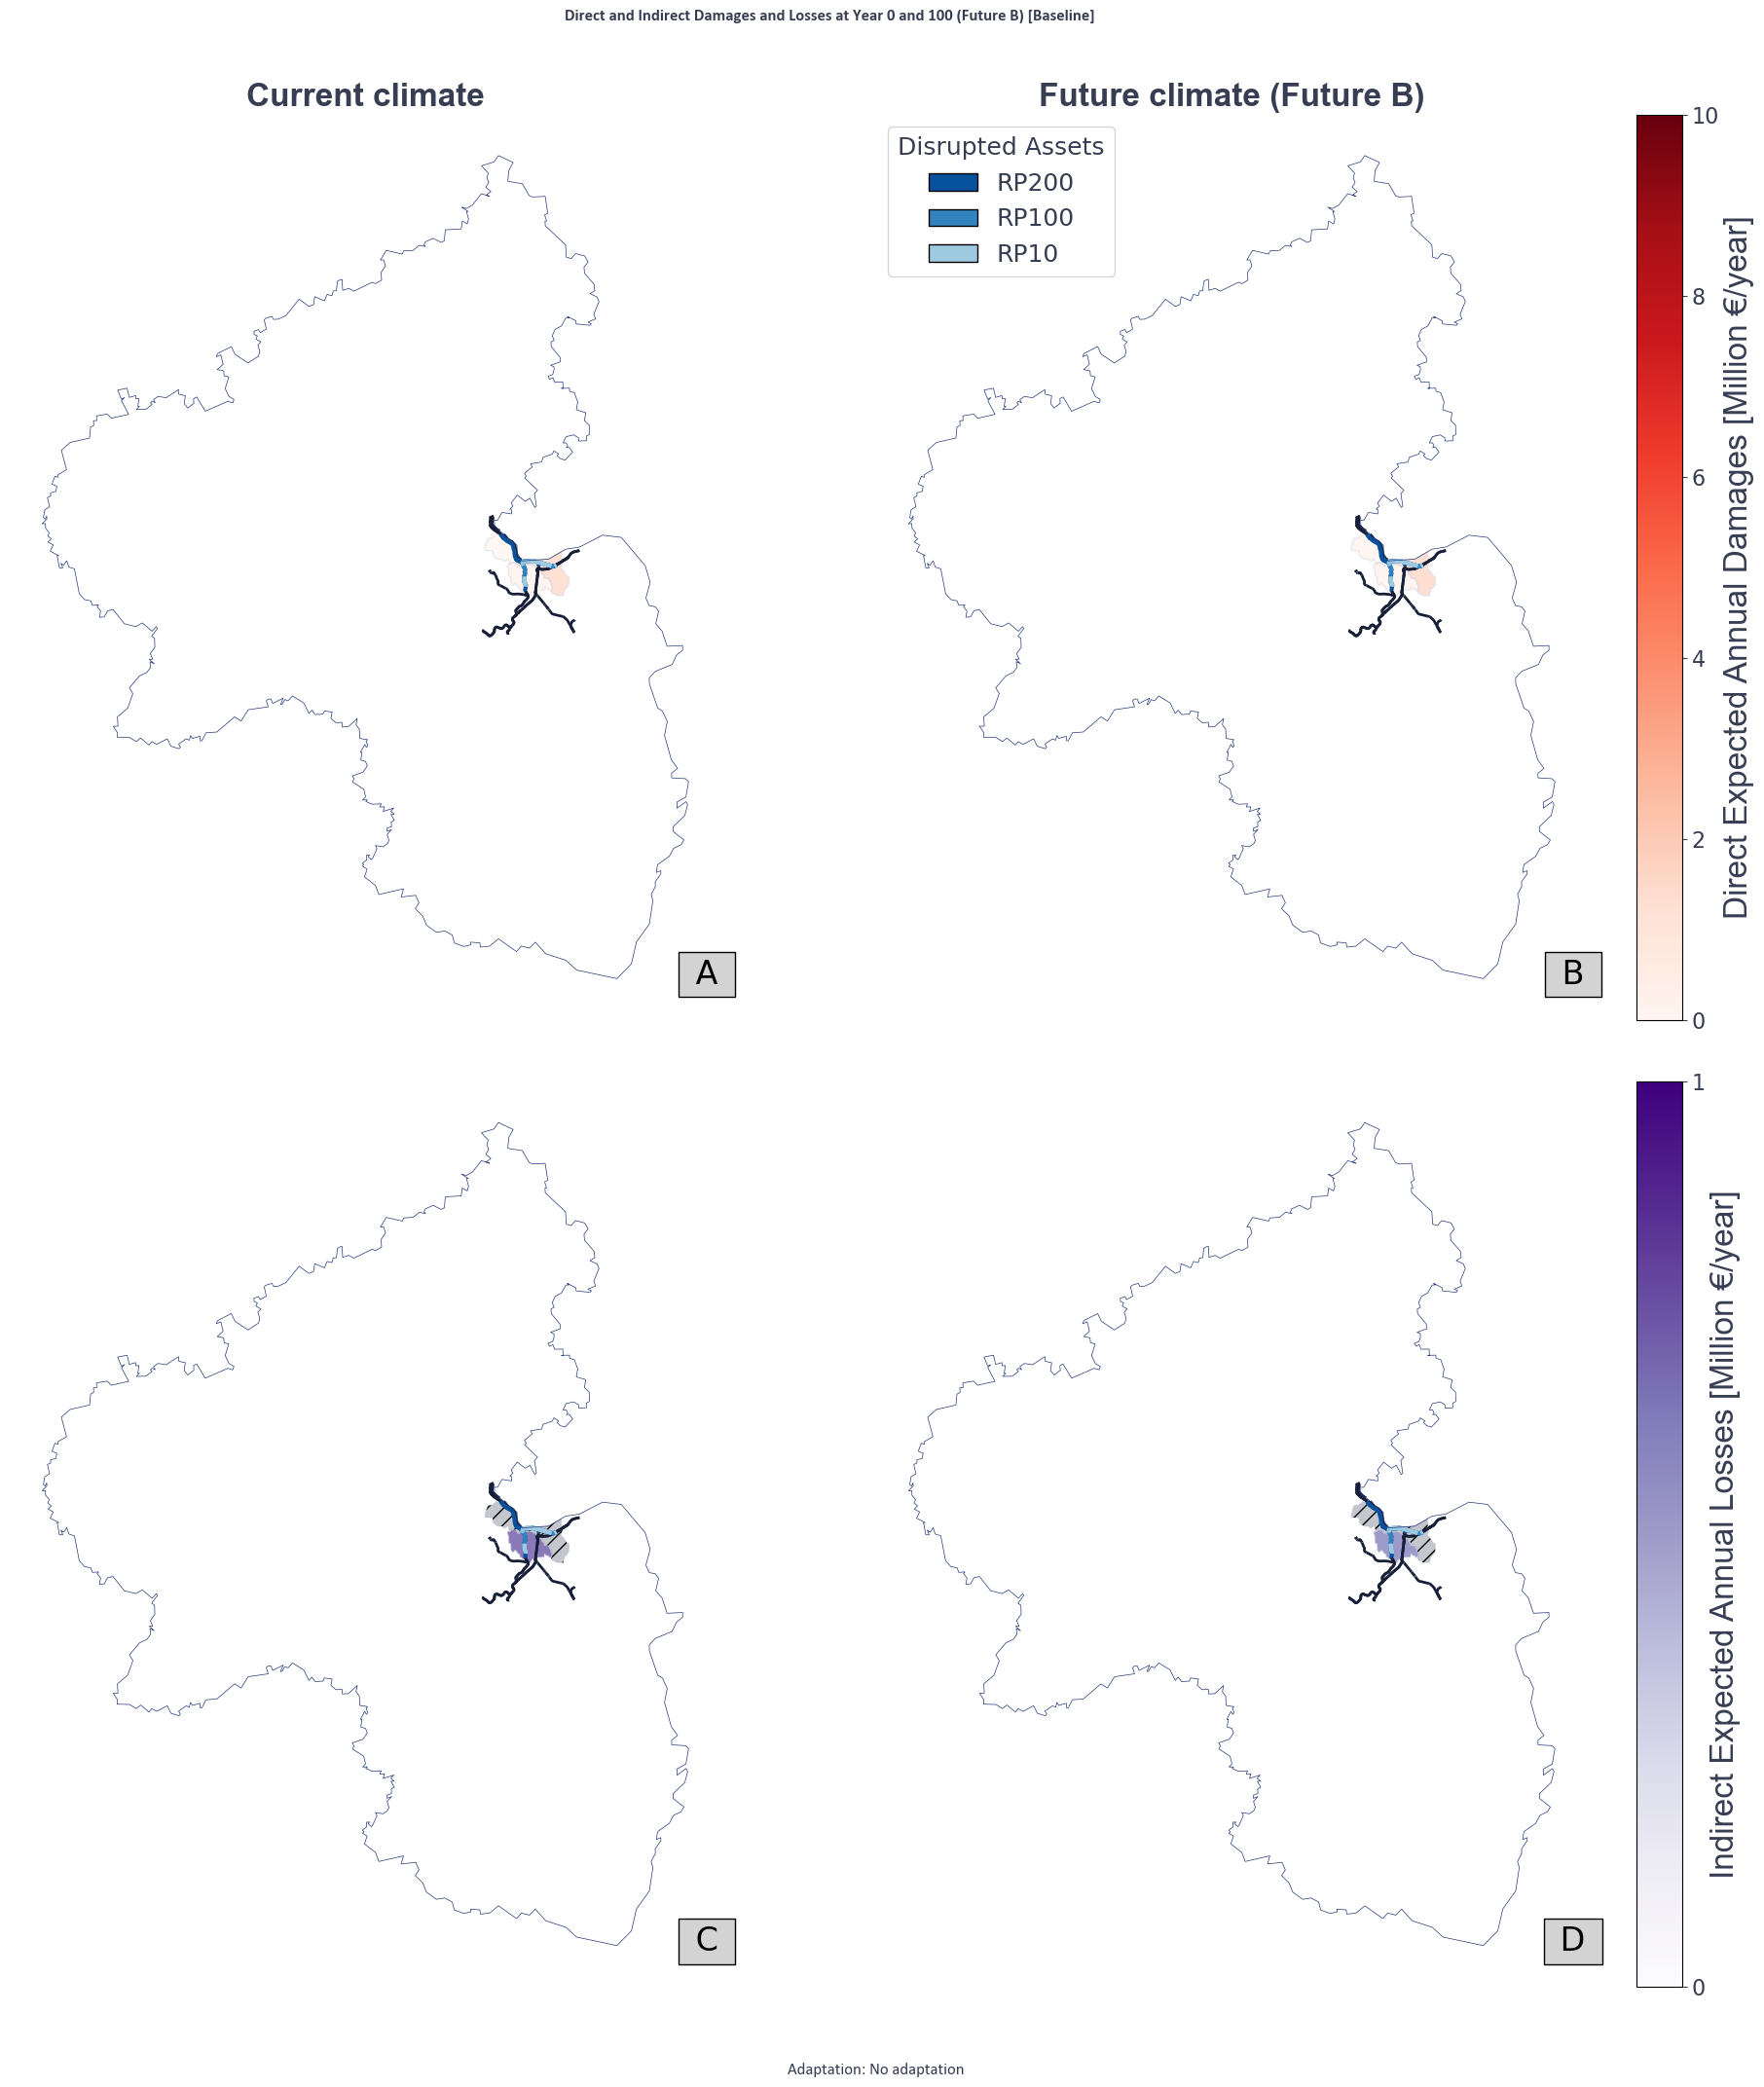

In [75]:
# Plot
fig, axs = plt.subplots(2, 2, figsize=(20, 20))
# Direct damages
# Plot for year 0
ax = 0, 0
vmax_dd = math.ceil(max([eadD_bl_by_ts_basin_incf['mean'][basin].values[0].max() for basin in eadD_bl_by_ts_basin_incf['mean']]) / 10.0) * 10
basins_gdf_reduced_clipped.plot(column='Average EAD_D_bl_t0', ax=axs[ax], legend=False, cmap='Reds', vmin=0, vmax=vmax_dd, alpha=0.8)
basins_gdf_reduced_clipped.plot(ax=axs[ax], edgecolor=miraca_colors['grey_200'], facecolor="None", alpha=0.5, linewidth=1)
axs[ax].set_title('Current climate', fontsize=size_set['title'], fontweight='bold', **mainfont)
# Plot for year 100
ax = 0, 1
valid_asset_ids = [asset_id for asset_id in asset_ids if asset_id in assets_4326_clipped.index]
basins_gdf_reduced_clipped.plot(column='Average EAD_D_bl_t100', ax=axs[ax], legend=False, cmap='Reds', vmin=0, vmax=vmax_dd, alpha=0.8)
basins_gdf_reduced_clipped.plot(ax=axs[ax], edgecolor=miraca_colors['grey_200'], facecolor="None", alpha=0.5, linewidth=1)
axs[ax].set_title('Future climate (Future B)', fontsize=size_set['title'], fontweight='bold', **mainfont)
# Add color bar and legend
sm1 = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=0, vmax=vmax_dd))
cbar1 = plt.colorbar(sm1, ax=axs[ax])
cbar1.set_label('Direct Expected Annual Damages [Million €/year]', fontsize=size_set['label'], **mainfont)
cbar1.ax.tick_params(labelsize=size_set['ticks'])
rp_letter_equiv = {'H': 'RP10', 'M': 'RP100', 'L': 'RP200'}
legend_elements = [mpatches.Patch(facecolor=dic_colors[rp_def], edgecolor='k', label=rp_letter_equiv[rp_def]) for rp_def in disrupted_asset_ids_filt.keys()]
axs[ax].legend(handles=legend_elements, title='Disrupted Assets', loc='upper left', fontsize=size_set['legend_label'], title_fontsize=size_set['legend_title'])
plt.setp(axs[ax].texts, family='Space Grotesk')

# Indirect losses, tributary basins
# Plot for year 0
ax = 1, 0
vmax_id = np.ceil(max([eadIT_bl_by_ts_basin_incf['mean'][basin].values[0].max() for basin in eadIT_bl_by_ts_basin_incf['mean']]))
basins_gdf_reduced_clipped.plot(column='EAD_ID_bl_t0', ax=axs[ax], legend=False, cmap='Purples', vmin=0, vmax=vmax_id, alpha=0.8)
basins_gdf_reduced_clipped.plot(ax=axs[ax], edgecolor=miraca_colors['grey_200'], facecolor="None", alpha=0.5, linewidth=1)
basins_gdf_reduced_clipped[basins_gdf_reduced_clipped['HYBAS_ID'].isin(main_basin_list)].plot(ax=axs[ax], edgecolor='None', facecolor=miraca_colors['grey_500'], alpha=0.5, linewidth=1, hatch='//')
axs[ax].set_title(' ', fontsize=size_set['title'])
# Plot for year 100
ax = 1, 1
basins_gdf_reduced_clipped.plot(column='EAD_ID_bl_t100', ax=axs[ax], legend=False, cmap='Purples', vmin=0, vmax=1.1*vmax_id, alpha=0.8)
basins_gdf_reduced_clipped.plot(ax=axs[ax], edgecolor=miraca_colors['grey_200'], facecolor="None", alpha=0.5, linewidth=1)
basins_gdf_reduced_clipped[basins_gdf_reduced_clipped['HYBAS_ID'].isin(main_basin_list)].plot(ax=axs[ax], edgecolor='None', facecolor=miraca_colors['grey_500'], alpha=0.5, linewidth=1, hatch='//')
axs[ax].set_title(' ', fontsize=size_set['title'])
# Add color bar
sm2 = plt.cm.ScalarMappable(cmap='Purples', norm=plt.Normalize(vmin=0, vmax=vmax_id))
cbar2 = plt.colorbar(sm2, ax=axs[ax], ticks=[0, 1, 2, 3, 4])
cbar2.set_label('Indirect Expected Annual Losses [Million €/year]', fontsize=size_set['label'], **mainfont)
cbar2.ax.tick_params(labelsize=size_set['ticks'])

# Plot static content
for ax in axs.flat:
    assets_4326_clipped.plot(ax=ax, color=miraca_colors['black'], lw=2)
    for rp_def, asset_ids in disrupted_asset_ids_filt.items():
        valid_asset_ids = [asset_id for asset_id in asset_ids if asset_id in assets_4326_clipped.index]
        assets_4326_clipped.loc[valid_asset_ids].plot(ax=ax, color=dic_colors[rp_def], lw=3)
    regions_gdf.boundary.plot(ax=ax, edgecolor=miraca_colors['blue_900'], linestyle='-', linewidth=0.5)
    ax.set_axis_off()

# Label as A, B, C, D in the bottom right corner with a grey background and black text
for i, ax in enumerate(axs.flat):
    ax.text(0.98, 0.05, f' {chr(65+i)} ', transform=ax.transAxes, fontsize=size_set['title'], fontweight='regular', color='black', ha='center', va='center', bbox=dict(facecolor='lightgrey', edgecolor='black', boxstyle='square,pad=0.2'))
plt.tight_layout()
plt.suptitle('Direct and Indirect Damages and Losses at Year 0 and 100 (Future B) [Baseline]', fontsize=size_set['suptitle'], fontweight='bold', y=1.03, **basefont)
plt.text(0, -0.1, f'Adaptation: No adaptation', ha='center', va='bottom', fontsize=size_set['suptitle'], transform=plt.gca().transAxes, **basefont)

plt.show()

Find the fraction of railways affected

In [76]:
# Save the exposed assets to a GeoJSON file
for rp_def, asset_ids in disrupted_asset_ids_filt.items():
    valid_asset_ids = [asset_id for asset_id in asset_ids if asset_id in assets_4326_clipped.index]
    assets_4326_clipped.loc[valid_asset_ids].to_parquet(data_path / 'output' / 'impacts' / f'exposed_assets_{rp_def}.pq')

output_disruption_summary_path = data_path / 'output' / 'disruption_summary.csv'
calculate_disruption_summary(disrupted_asset_ids_filt, assets_4326_clipped, assets, save_to_csv=True, output_path=output_disruption_summary_path)

Total exposed assets: 73
Total assets: 537
Fraction of disrupted assets: 0.14
Fraction of disrupted asset by length: 0.23


Zooming to the areas with adapted assets

Applying adaptation: new connection between assets with osm_id  (219651487, 111997047)
Level 3 adaptation
Applying adaptation: shifted demand for routes:  [('node_682', 'node_684'), ('node_684', 'node_682'), ('node_260', 'node_387'), ('node_387', 'node_260'), ('node_387', 'node_434'), ('node_387', 'node_286'), ('node_434', 'node_387'), ('node_286', 'node_387')]
Level 4 adaptation


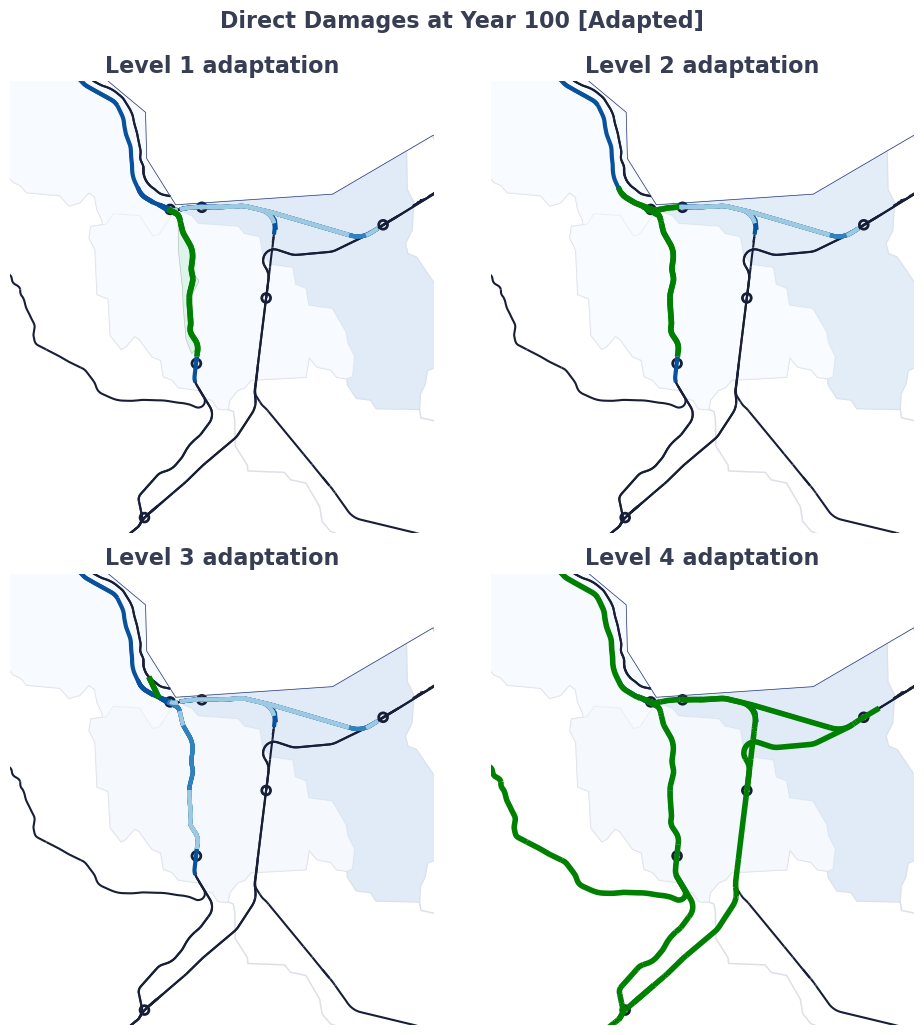

In [77]:
# Plot
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Find value max for color bars assuming baseline conditions have higher damages than adapted conditions
baseline_basins_gdf = prep_adapted_basins_gdf(basins_gdf_0, eadD_ad_by_ts_basin_incf, eadIT_ad_by_ts_basin_incf, adapt_id='baseline', inc_f='mean', clipping_gdf=regions_gdf)
vmax_dd = math.ceil(max([baseline_basins_gdf['Average EAD_D_ad_t0'].max(), baseline_basins_gdf['Average EAD_D_ad_t100'].max()]) / 10.0) * 10
vmax_id = np.ceil(max([baseline_basins_gdf['EAD_ID_ad_t0'].max(), baseline_basins_gdf['EAD_ID_ad_t100'].max()])) 
adapted_basins_list = find_adapted_basin(eadD_ad_by_ts_basin_incf, eadIT_ad_by_ts_basin_incf, adapt_id='l1_trib')
# xmin, ymin, xmax, ymax = basins_gdf[basins_gdf['HYBAS_ID']==2080430320].total_bounds
xmin, ymin, xmax, ymax = basins_gdf[basins_gdf['HYBAS_ID'].isin(adapted_basins_list)].total_bounds
buffer = 0.05
xmin -= buffer
ymin -= buffer
xmax += buffer
ymax += buffer

# Plot standard elements for all subplots
for ax in axs.flat:
    assets_4326_clipped.plot(ax=ax, color=miraca_colors['black'], markersize=1)
    for rp_def, asset_ids in disrupted_asset_ids_filt.items():
        valid_asset_ids = [asset_id for asset_id in asset_ids if asset_id in assets_4326_clipped.index]
        assets_4326_clipped.loc[valid_asset_ids].plot(ax=ax, color=dic_colors[rp_def], markersize=2, linewidth=3)
    baseline_basins_gdf.plot(ax=ax, edgecolor=miraca_colors['grey_200'], facecolor="None", alpha=0.5, linewidth=1)
    regions_gdf.boundary.plot(ax=ax, edgecolor=miraca_colors['blue_900'], linestyle='-', linewidth=0.5)

    ax.set_axis_off()
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)    

# Level 1 adaptation
# Plot for year 100
ax = 0, 0
adapt_id = 'l1_trib'
adapted_basins_gdf = prep_adapted_basins_gdf(basins_gdf, eadD_ad_by_ts_basin_incf, eadIT_ad_by_ts_basin_incf, adapt_id=adapt_id, inc_f='mean', clipping_gdf=regions_gdf)
adapted_basins_gdf.plot(column='Average EAD_D_ad_t100', ax=axs[ax], legend=False, cmap='Blues', vmin=0, vmax=vmax_dd, alpha=0.8)
axs[ax].set_title('Level 1 adaptation', fontsize=16, fontweight='bold')
# kevel 1 adaptation is a gdf of the protected area and a filter of the protected assets
gdf_prot_area = gpd.read_file(data_path / 'input' / 'adaptations' /  'l1_tributary.geojson')
assets_adapt=filter_assets_to_adapt(assets_4326_clipped.to_crs(3857), gdf_prot_area.to_crs(3857))
assets_adapt=assets_adapt.to_crs(4326)
gdf_prot_area.plot(ax=axs[ax], edgecolor='black', facecolor=miraca_colors['green_success'], alpha=0.2, linewidth=0.5)
assets_adapt.plot(ax=axs[ax], color='green', lw=4)
assets_adapt.to_file(data_path / 'output' / 'adaptations' / 'l1_tributary_assets.geojson', driver='GeoJSON')

# Level 2 adaptation
# Plot for year 100
ax = 0, 1
adapt_id = 'l2_trib'
adapted_basins_gdf = prep_adapted_basins_gdf(basins_gdf, eadD_ad_by_ts_basin_incf, eadIT_ad_by_ts_basin_incf, adapt_id=adapt_id, inc_f='mean', clipping_gdf=regions_gdf)
adapted_basins_gdf.plot(column='Average EAD_D_ad_t100', ax=axs[ax], legend=False, cmap='Blues', vmin=0, vmax=vmax_dd, alpha=0.8)
axs[ax].set_title('Level 2 adaptation', fontsize=16, fontweight='bold')
# level 2 adaptation is a gdf of the filter of the protected assets
gdf_prot_area = gpd.read_file(data_path / 'input' / 'adaptations' /  'l2_tributary.geojson')
assets_adapt=filter_assets_to_adapt(assets_4326_clipped.to_crs(3857), gdf_prot_area.to_crs(3857))
assets_adapt=assets_adapt.to_crs(4326)
assets_adapt.plot(ax=axs[ax], color='green', lw=4)
assets_adapt.to_file(data_path / 'output' / 'adaptations' / 'l2_tributary_assets.geojson', driver='GeoJSON')

# Level 3 adaptation
# Plot for year 100
ax = 1, 0
adapt_id = 'l3_trib'
adapted_basins_gdf = prep_adapted_basins_gdf(basins_gdf, eadD_ad_by_ts_basin_incf, eadIT_ad_by_ts_basin_incf, adapt_id=adapt_id, inc_f='mean', clipping_gdf=regions_gdf)
adapted_basins_gdf.plot(column='Average EAD_D_ad_t100', ax=axs[ax], legend=False, cmap='Blues', vmin=0, vmax=vmax_dd, alpha=0.8)
axs[ax].set_title('Level 3 adaptation', fontsize=16, fontweight='bold')
# level 3 adaptation is a gdf of new connections between the protected assets
added_links = [(219651487, 111997047)]
for i,osm_id_pair in enumerate(added_links):
        graph_v, _ = add_l3_adaptation(graph_r0, osm_id_pair)
gdf_l3_edges = get_l3_gdf(added_links, graph_v)
gdf_l3_edges.plot(ax=axs[ax], color='green', lw=4)
gdf_l3_edges.to_file(data_path / 'output' / 'adaptations' / 'l3_tributary_edges_b.geojson', driver='GeoJSON')

# Level 4 adaptation
# Plot for year 100
ax = 1, 1
adapt_id = 'l4_trib'
adapted_basins_gdf = prep_adapted_basins_gdf(basins_gdf, eadD_ad_by_ts_basin_incf, eadIT_ad_by_ts_basin_incf, adapt_id=adapt_id, inc_f='mean', clipping_gdf=regions_gdf)
adapted_basins_gdf.plot(column='Average EAD_D_ad_t100', ax=axs[ax], legend=False, cmap='Blues', vmin=0, vmax=vmax_dd, alpha=0.8)
axs[ax].set_title('Level 4 adaptation', fontsize=16, fontweight='bold')
# level 4 adaptation is a gdf with the assets in shortest paths with reduced demand
adapted_route_area = gpd.read_file(data_path / 'input' / 'adaptations' /  'l4_tributary.geojson')
demand_reduction_dict = add_l4_adaptation(graph_r0, shortest_paths, adapted_route_area.to_crs(3857))   
assets_in_paths = list(set([asset_id for od, (asset_ids, demand) in get_asset_ids_from_sps(shortest_paths, graph_r0).items() for asset_id in asset_ids if asset_id != '']))
assets_adapt=assets_4326_clipped[assets_4326_clipped['osm_id'].isin(assets_in_paths)]
assets_adapt.plot(ax=axs[ax], color='green', lw=4)
assets_adapt.to_file(data_path / 'output' / 'adaptations' / 'l4_tributary_assets.geojson', driver='GeoJSON')

for ax in axs.flat:
    od_geoms_plot.to_crs(4326).plot(ax=ax, edgecolor=miraca_colors['black'], facecolor="None", markersize=40, linewidth=2)

plt.tight_layout()
plt.suptitle('Direct Damages at Year 100 [Adapted]', fontsize=16,
             fontweight='bold',
             y=1.03)
plt.savefig(data_path / 'output' / 'plots' / 'adaptations_disrupted_assets.png', dpi=300)
plt.show()


Produce processed output tables

In [78]:

# Neat table of adaptations for both case studies with descending BCRs, benefits, and costs
adaptation_table = pd.DataFrame()
dict_tags_names = {'l1': 'L1: flood wall', 
                         'l2': 'L2: elevate rail (viaduct)', 
                         'l3': 'L3: build new connection', 
                         'l4': 'L4: reduce demand', 
                         'trib': 'Study Area 2',
                         'rhine': 'Study Area 1',
                         'baseline': 'No adaptation',
                         'upper bound': 'Future C',
                         'lower bound': 'Future A', 
                         'mean': 'Future B'}

for adapt_id in adapt_ids_output:
    if adapt_id == 'baseline': continue
    name_components = adapt_id.split('_')
    adaptation_name = dict_tags_names[name_components[0]]
    study_area = dict_tags_names[name_components[1]] if len(name_components) > 1 else 'Unknown'
    for inc_f in increase_factors_bounds.keys():
        bcr_values = bcr_df.loc[adapt_id]['bcr_'+inc_f.split(' ')[0]].mean()
        # npv_values = npv_df.loc[adapt_id]['npv_mean'].mean()
        benefits = benefits_dict[adapt_id][inc_f]['total_avoided_damages_full_period'].mean()
        costs = processed_adaptation_costs[adapt_id]
        # new_row = pd.DataFrame({'Adaptation': [adapt_id], 'BCR': [bcr_values], 'Benefits': [benefits], 'Costs': [costs]})
        new_row = pd.DataFrame({'Adaptation': [adaptation_name], 'Study Area': [study_area], 'BCR': [bcr_values], 'Benefits': [benefits], 'Costs': [costs]})
        adaptation_table = pd.concat([adaptation_table, new_row], ignore_index=True)

# make study area a level for sorting and merge all the rows in a single cell
adaptation_table['Study Area'] = pd.Categorical(adaptation_table['Study Area'], ['Study Area 1', 'Study Area 2', 'Unknown'])
adaptation_table = adaptation_table.sort_values(by=['Study Area', 'BCR'], ascending=[True, False])
# adaptation_table = adaptation_table.sort_values(by='BCR', ascending=False)
adaptation_table.to_csv(data_path / 'output' / 'adaptation_table.csv')
adaptation_table


,Adaptation,Study Area,BCR,Benefits,Costs
5,L2: elevate rail (viaduct),Study Area 2,0.098,141.086,"1,360.178"
4,L2: elevate rail (viaduct),Study Area 2,0.086,117.468,"1,360.178"
3,L2: elevate rail (viaduct),Study Area 2,0.074,91.740,"1,360.178"
2,L1: flood wall,Study Area 2,0.068,27.082,435.727
1,L1: flood wall,Study Area 2,0.049,21.343,435.727
0,L1: flood wall,Study Area 2,0.029,15.079,435.727
6,L3: build new connection,Study Area 2,0.000,0.000,215.266
7,L3: build new connection,Study Area 2,0.000,0.000,215.266
8,L3: build new connection,Study Area 2,0.000,0.000,215.266
9,L4: reduce demand,Study Area 2,0.000,22.575,0.000


In [79]:
bcr_df_beautified = bcr_df.copy()
bcr_df_beautified['Adaptation'] = bcr_df_beautified.index.map(lambda x: dict_tags_names[x[0].split('_')[0]])
bcr_df_beautified['Study Area'] = bcr_df_beautified.index.map(lambda x: dict_tags_names[x[0].split('_')[1]] if len(x[0].split('_')) > 1 else 'Unknown')
bcr_df_beautified['Future Climate'] = bcr_df_beautified.index.map(lambda x: dict_tags_names[x[1]])
bcr_df_beautified['string_id'] = bcr_df_beautified.index.map(lambda x: x[0] + '_' + x[1])

#add index level to dataframe (study area)
bcr_df_beautified = bcr_df_beautified.reset_index()
bcr_df_beautified.set_index(['Study Area', 'Adaptation', 'Future Climate'], inplace=True)
bcr_df_beautified = bcr_df_beautified.sort_index()

# New formatted columns
bcr_df_beautified['Benefits (M€)'] = bcr_df_beautified['total_avoided_damages'].map(lambda x: f'{x.mean():.0f}') + ' (' + bcr_df_beautified['total_avoided_damages_lower'].map(lambda x: f'{x:.0f}') + ' - ' + bcr_df_beautified['total_avoided_damages_upper'].map(lambda x: f'{x:.0f}') + ')'
bcr_df_beautified['Costs (M€)'] = bcr_df_beautified['total_adaptation_cost'].map(lambda x: f'{x:.0f}')
bcr_df_beautified['BCR avg (range)'] = bcr_df_beautified['bcr'].map(lambda x: f'{x.mean():.2f}') + ' (' + bcr_df_beautified['bcr_lower'].map(lambda x: f'{x:.2f}') + ' - ' + bcr_df_beautified['bcr_upper'].map(lambda x: f'{x:.2f}') + ')'

# Drop unnecessary columns
drop_cols=['total_avoided_damages','total_avoided_damages_lower', 'total_avoided_damages_mean','total_avoided_damages_upper',  'total_adaptation_cost', 'bcr', 'bcr_mean', 'bcr_lower', 'bcr_upper', 'level_0', 'level_1']
bcr_df_beautified.drop(columns=drop_cols, inplace=True)

# move string id to last column
bcr_df_beautified = bcr_df_beautified[['Benefits (M€)', 'Costs (M€)', 'BCR avg (range)', 'string_id']]

bcr_df_beautified


Benefits (M€)  \
Study Area   Adaptation                 Future Climate                    
Study Area 2 L1: flood wall             Future A           15 (10 - 20)   
                                        Future B           21 (13 - 30)   
                                        Future C           27 (16 - 38)   
             L2: elevate rail (viaduct) Future A          92 (80 - 103)   
                                        Future B        117 (101 - 134)   
                                        Future C        141 (120 - 162)   
             L3: build new connection   Future A              0 (0 - 0)   
                                        Future B              0 (0 - 0)   
                                        Future C              0 (0 - 0)   
             L4: reduce demand          Future A           23 (23 - 23)   
                                        Future B           28 (28 - 28)   
                                        Future C           32 (32 - 32)   
Unknown      No adaptation              Future A              0 (0 - 0)   
                                        Future B              0 (0 - 0)   
                                        Future C              0 (0 - 0)   

                                                       Costs (M€)  \
Study Area   Adaptation                 Future Climate              
Study Area 2 L1: flood wall             Future A              436   
                                        Future B              436   
                                        Future C              436   
             L2: elevate rail (viaduct) Future A             1360   
                                        Future B             1360   
                                        Future C             1360   
             L3: build new connection   Future A              215   
                                        Future B              215   
                                        Future C              215   
             L4: reduce demand          Future A                0   
                                        Future B                0   
                                        Future C                0   
Unknown      No adaptation              Future A                0   
                                        Future B                0   
                                        Future C                0   

                                                           BCR avg (range)  \
Study Area   Adaptation                 Future Climate                       
Study Area 2 L1: flood wall             Future A        0.03 (0.02 - 0.05)   
                                        Future B        0.05 (0.03 - 0.07)   
                                        Future C        0.06 (0.04 - 0.09)   
             L2: elevate rail (viaduct) Future A        0.07 (0.06 - 0.08)   
                                        Future B        0.09 (0.07 - 0.10)   
                                        Future C        0.10 (0.09 - 0.12)   
             L3: build new connection   Future A        0.00 (0.00 - 0.00)   
                                        Future B        0.00 (0.00 - 0.00)   
                                        Future C        0.00 (0.00 - 0.00)   
             L4: reduce demand          Future A        0.00 (0.00 - 0.00)   
                                        Future B        0.00 (0.00 - 0.00)   
                                        Future C        0.00 (0.00 - 0.00)   
Unknown      No adaptation              Future A        0.00 (0.00 - 0.00)   
                                        Future B        0.00 (0.00 - 0.00)   
                                        Future C        0.00 (0.00 - 0.00)   

                                                                   string_id  
Study Area   Adaptation                 Future Climate                        
Study Area 2 L1: flood wall             Future A         l1_trib_lower bound  
                                        Futu